# ANAC


In [564]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, normalize

#### Seed

In [565]:
seed = 2024
np.random.seed(seed)

In [566]:
diet_csv = pd.read_csv("diet.csv").copy()
recipes_csv = pd.read_csv("recipes.csv").copy()
requests_csv = pd.read_csv("requests.csv").copy()
reviews_csv = pd.read_csv("reviews.csv").copy()

/var/folders/z0/24mzs0z565s6qpzztgbdrj780000gn/T/ipykernel_7933/3884275055.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  reviews_csv = pd.read_csv("reviews.csv").copy()


***Join Dataset***

In [567]:
# merge diet + request
request_with_diet = pd.merge(diet_csv, requests_csv, how="inner", on="AuthorId")
# merge diet + request + recipe
request_with_diet_and_recipe = pd.merge(recipes_csv, request_with_diet, how="inner", on="RecipeId")
# merge diet + request + recipe + review
df = pd.merge(reviews_csv, request_with_diet_and_recipe, how="inner", on=["AuthorId", "RecipeId"])
# merge whole df with own generated RecipeMatchesDiet

### Data Cleaning

#### Basics

In [568]:
# drop na diet column
df = df.dropna(subset=['Diet'])
# Rename AuthorId column
df.rename(columns= {
    "AuthorId" : "CustomerId", 
    "Time": "MaxTime"
}, inplace=True)

df["Like"] = df["Like"].astype("boolean")
# Change types into category and mapping values
df["Diet"] = df["Diet"].astype("category")

df["RecipeCategory"] = df["RecipeCategory"].astype("category")

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighCalories'] = df['HighCalories'].map(mapping_cal).astype('category')

mapping_protein = {'Yes': 'Yes', 'Indifferent': 'Indifferent', 'No': 'No' }
df['HighProtein'] = df['HighProtein'].map(mapping_protein).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['LowFat'] = df['LowFat'].map(mapping_cal).astype('category')

mapping_sugar = {'1': 'Yes', 'Indifferent': 'Indifferent', '0': 'No' }
df['LowSugar'] = df['LowSugar'].map(mapping_sugar).astype('category')

mapping_cal = {1: 'Yes', 0.0: 'No'}
df['HighFiber'] = df['HighFiber'].map(mapping_cal).astype('category')

# Remove NA rows and Rating column
df = df.drop("Rating", axis=1)


# One hot encoding for categorical variables
df = pd.get_dummies(df, columns=['Diet', 'HighCalories', 'LowFat', 'HighFiber', 'HighProtein', 'LowSugar'], drop_first=True)

df.rename(columns={
    'HighCalories_Yes': 'want_HighCalories',
    'LowFat_Yes':'want_LowFat',
    'HighFiber_Yes':'want_HighFiber',
    'HighProtein_Yes':'want_HighProtein',
}, inplace=True)

df["DifferenceRequestedAndTimeNeeded"] = df["MaxTime"] - (df["CookTime"] + df["PrepTime"])
df["TotalTimeNeeded"] = df["CookTime"] + df["PrepTime"]

In [569]:
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace(")", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("(", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\"", '')
df["RecipeIngredientParts"] = df["RecipeIngredientParts"].str.replace("\\", '')
df['RecipeIngredientParts'] = df['RecipeIngredientParts'].str.replace('^c', '', regex=True)

def check_keywords(ingredients):
    has_animal_product = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "milk", "butter", "egg", "cheese", "breast", "gelatin", "honey", "tuna", "steak", "salmon", "shrimps"]) for ingredient in ingredients)
    has_fish_or_meat = any(any(keyword in ingredient.lower() for keyword in ["meat", "chicken", "lamb", "beef", "pork", "bacon", "fish", "sausage", "turkey", "tuna", "steak", "salmon", 'shrimps']) for ingredient in ingredients)
    return has_animal_product, has_fish_or_meat

df[['has_animal_product', 'has_fish_meat']] = df['RecipeIngredientParts'].str.split(',').apply(check_keywords).apply(pd.Series)

df['for_Vegan'] = ~df['has_animal_product'] & ~df['has_fish_meat']
df['for_Vegetarian'] = (df['has_animal_product'] & ~df['has_fish_meat']) | (~df['has_animal_product'] & ~df['has_fish_meat'])
df['Correct_Diet'] = (~df['Diet_Vegetarian'] & ~df['Diet_Vegan']) | (df['Diet_Vegan'] & df['for_Vegan']) | (df['Diet_Vegetarian']  & df['for_Vegetarian'] )



***Split data***

In [570]:
# Split data into train and test set
train_set = df[df["TestSetId"].isna()]
test_set = df[df["TestSetId"].notnull()]

In [601]:
test_set

,CustomerId,RecipeId,Like,TestSetId,Name,CookTime,PrepTime,RecipeCategory,RecipeIngredientQuantities,RecipeIngredientParts,...,want_HighFiber,want_HighProtein,LowSugar_No,DifferenceRequestedAndTimeNeeded,TotalTimeNeeded,has_animal_product,has_fish_meat,for_Vegan,for_Vegetarian,Correct_Diet
0,2492191A,33671,<NA>,1.0,"Chorizo, Pepper &amp; Eggplant Pasta Bake",1500,1200,One dish meal,"c(""\""7\"""", ""\""2\"""", ""\""1\"""", ""\""1\"""", ""\""2\"""",...","chorizo sausage, eggplant, garlic clove, artif...",...,True,False,True,-1.285624,2700,True,True,False,False,True
1,2002019979A,92647,<NA>,2.0,Pork and Chickpea Chili,1200,1200,Other,"c(""\""1\"""", ""\""2/3\"""", ""\""1\"""", ""\""1\"""", ""\""1\""...","ground pork, scallion, garlic, chickpeas, homi...",...,True,False,False,-0.305417,2400,True,True,False,False,True
2,408594E,161770,<NA>,3.0,Stuffed Zucchini With Sausage,1200,900,Other,"c(""\""4\"""", ""\""1/2\"""", ""\""1/2\"""", ""\""2\"""", ""\""2...","zucchini, Italian sausage, romano cheese, pine...",...,True,False,True,-0.886830,2100,True,True,False,False,True
3,2001625557E,108231,<NA>,4.0,Cream Cheese and Beef Cracker Spread,0,1200,Other,"c(""\""16\"""", ""\""2\"""", ""\""1\"""", ""\""5\"""")","cream cheese, garlic cloves, green onion, beef",...,True,True,True,-0.354425,1200,True,True,False,False,True
4,2001427116E,71109,<NA>,5.0,Greek Lemon Chicken Kabobs With Mint Marinade,840,1500,Other,"c(""\""4\"""", ""\""1\"""", ""\""1/4\"""", ""\""1\"""", ""\""1\""...","boneless skinless chicken breast halves, whole...",...,True,False,True,1.181827,2340,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42809,2000357827D,194823,<NA>,42810.0,Philadelphia Caramel-Pecan Cheesecake,2700,900,Other,"c(""\""1 1/2\"""", ""\""1\"""", ""\""1/4\"""", ""\""4\"""", ""\...","pecans, Philadelphia Cream Cheese, sugar, sour...",...,False,True,True,0.286373,3600,True,False,False,True,True
42810,2000357827D,35775,<NA>,42811.0,Sweet Dreams Crunch Cherry Dump Cake,3600,300,Other,"c(""\""1\"""", ""\""1\"""", ""\""1/2\"""")","cherry pie filling, lemon juice, butter",...,True,False,False,0.022844,3900,True,False,False,True,True
42811,2915363A,26820,<NA>,42812.0,Appetizers-Easy Stuffed Mushrooms,420,2100,Other,"c(""\""8\"""", ""\""3\"""", ""\""1/4\"""", ""\""1/4\"""", ""\""1...","fresh mushrooms, butter, celery, onion, Worces...",...,False,False,True,-1.251749,2520,True,False,False,True,True
42812,2001538344B,512974,<NA>,42813.0,"Wild Rice, Brown Rice and Dried Fruit Pilaf",2400,1800,Other,"c(""\""3/4\"""", ""\""3/4\"""", ""\""4\"""", ""\""1/2\"""", ""\...","wild rice, brown rice, pecans, green onion, dr...",...,False,True,True,-0.132453,4200,False,False,True,True,True


# Handling outliers

In [571]:
train_set = train_set[train_set["Calories"] < 300000]

### Missing values

In [572]:
train_set.dropna(subset=["Like"], inplace=True)
train_set = train_set.drop("TestSetId", axis=1)

In [573]:
# needs to be done after outlier removal
recipesServings_mean = train_set['RecipeServings'].mean()
#fill na rows with the mean
train_set.loc[:, 'RecipeServings'] = train_set['RecipeServings'].fillna(recipesServings_mean)
test_set.loc[:, 'RecipeServings'] = test_set['RecipeServings'].fillna(recipesServings_mean)

# Train model for each category


In [574]:
soup_subset = train_set[train_set['RecipeCategory'] == 'Soup']
lunch_subset = train_set[train_set['RecipeCategory'] == 'Lunch']
breakfast_subset = train_set[train_set['RecipeCategory'] == 'Breakfast']
bread_subset = train_set[train_set['RecipeCategory'] == 'Bread']
one_dish_meal_subset = train_set[train_set['RecipeCategory'] == 'One dish meal']
other_subset = train_set[train_set['RecipeCategory'] == 'Other']
beverages_subset = train_set[(train_set['RecipeCategory'] == 'Beverages')]

models = []
predictions = []

## Soup

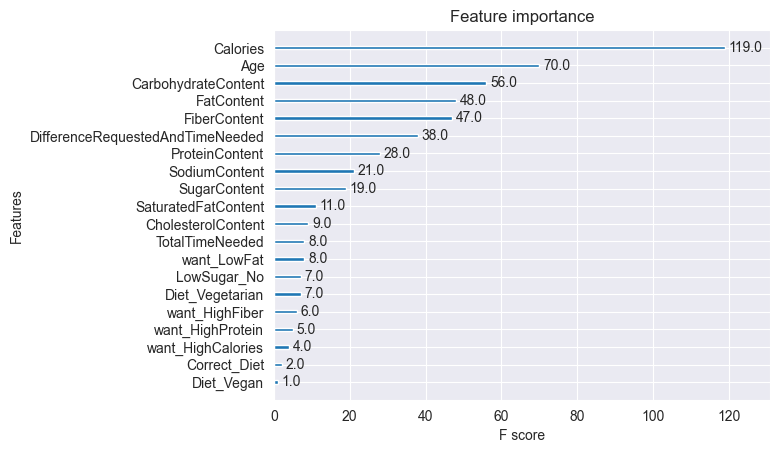

In [575]:
from imblearn.under_sampling import RandomUnderSampler

soup_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product','RecipeCategory', 'PrepTime', 'CookTime','RecipeServings' ]
X = soup_subset.drop(soup_variables_to_drop, axis=1)
y = soup_subset['Like']

X_train, X_test, y_train, y_test_soup = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

model_soup = XGBRegressor(n_estimators=100, random_state=seed)
model_soup.fit(X_train, y_train)
plot_importance(model_soup)
plt.show()

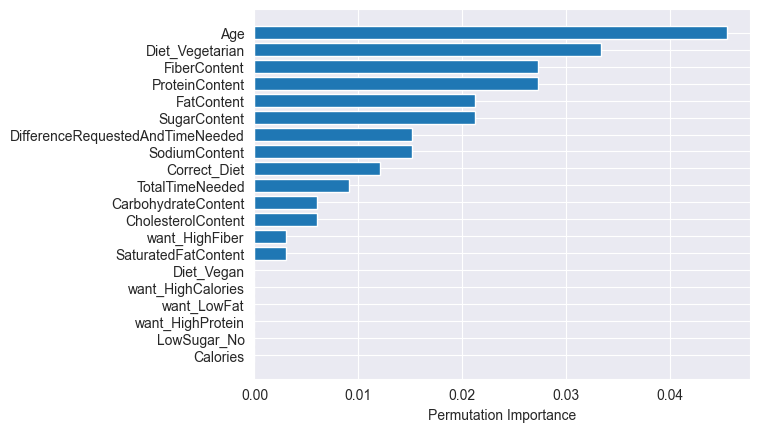

In [576]:
model_soup = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_soup.fit(X_train, y_train)
models.append(model_soup)

# for the plot
perm_importance = permutation_importance(model_soup, X_test, y_test_soup)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.7918032786885245


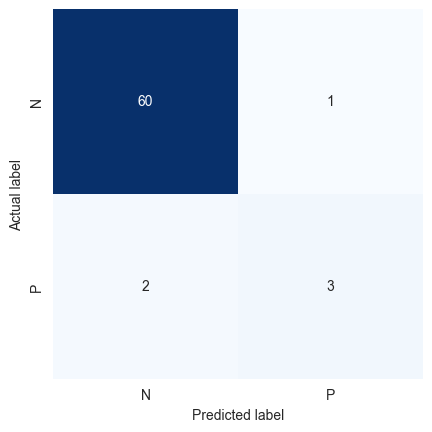

In [577]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_soup.predict(X_test) > 0.5
mat = confusion_matrix(y_test_soup, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_soup = balanced_accuracy_score(y_test_soup, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_soup}')

TN_Soup, FP_Soup = mat[0, 0], mat[0, 1]
FN_Soup, TP_Soup = mat[1, 0], mat[1, 1]

## Lunch

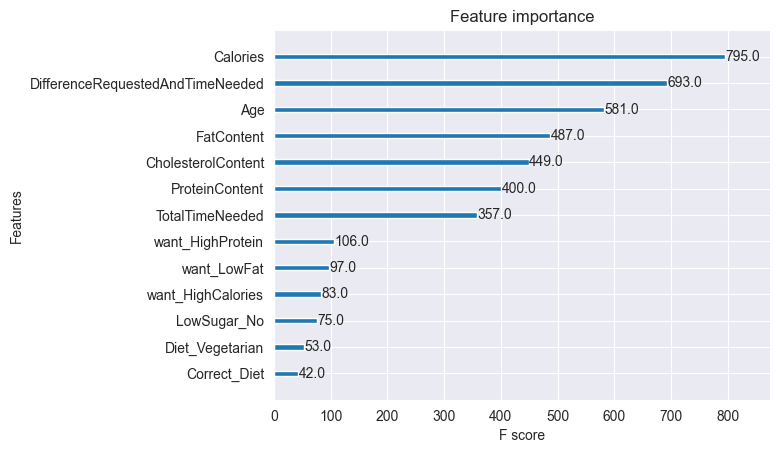

In [578]:
lunch_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime','RecipeCategory', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product','SaturatedFatContent', 'RecipeServings', 'CarbohydrateContent', 'SodiumContent', 'SugarContent', 'CookTime', 'PrepTime', 'Diet_Vegan', 'FiberContent', 'want_HighFiber' ]
X = lunch_subset.drop(lunch_variables_to_drop, axis=1)
y = lunch_subset['Like']

X_train, X_test, y_train, y_test_lunch = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3, 
                     stratify=y)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

model_lunch = XGBRegressor(n_estimators=100, random_state=seed)
model_lunch.fit(X_train, y_train)


# Plot feature importance
plot_importance(model_lunch)
plt.show()

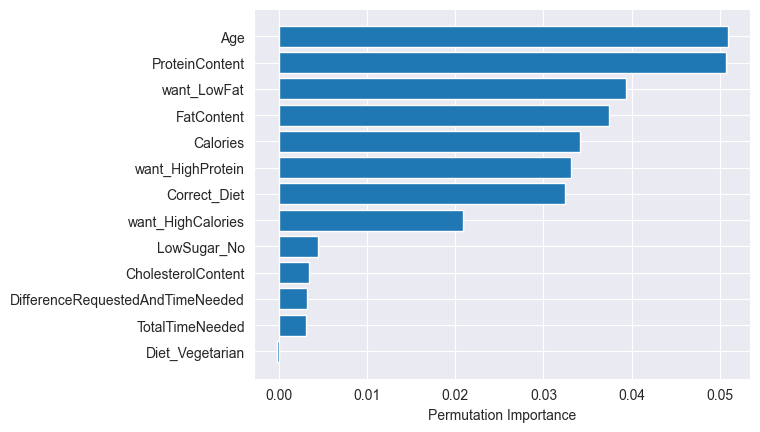

In [579]:
model_lunch = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_lunch.fit(X_train, y_train)
models.append(model_lunch)

perm_importance = permutation_importance(model_lunch, X_test, y_test_lunch)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

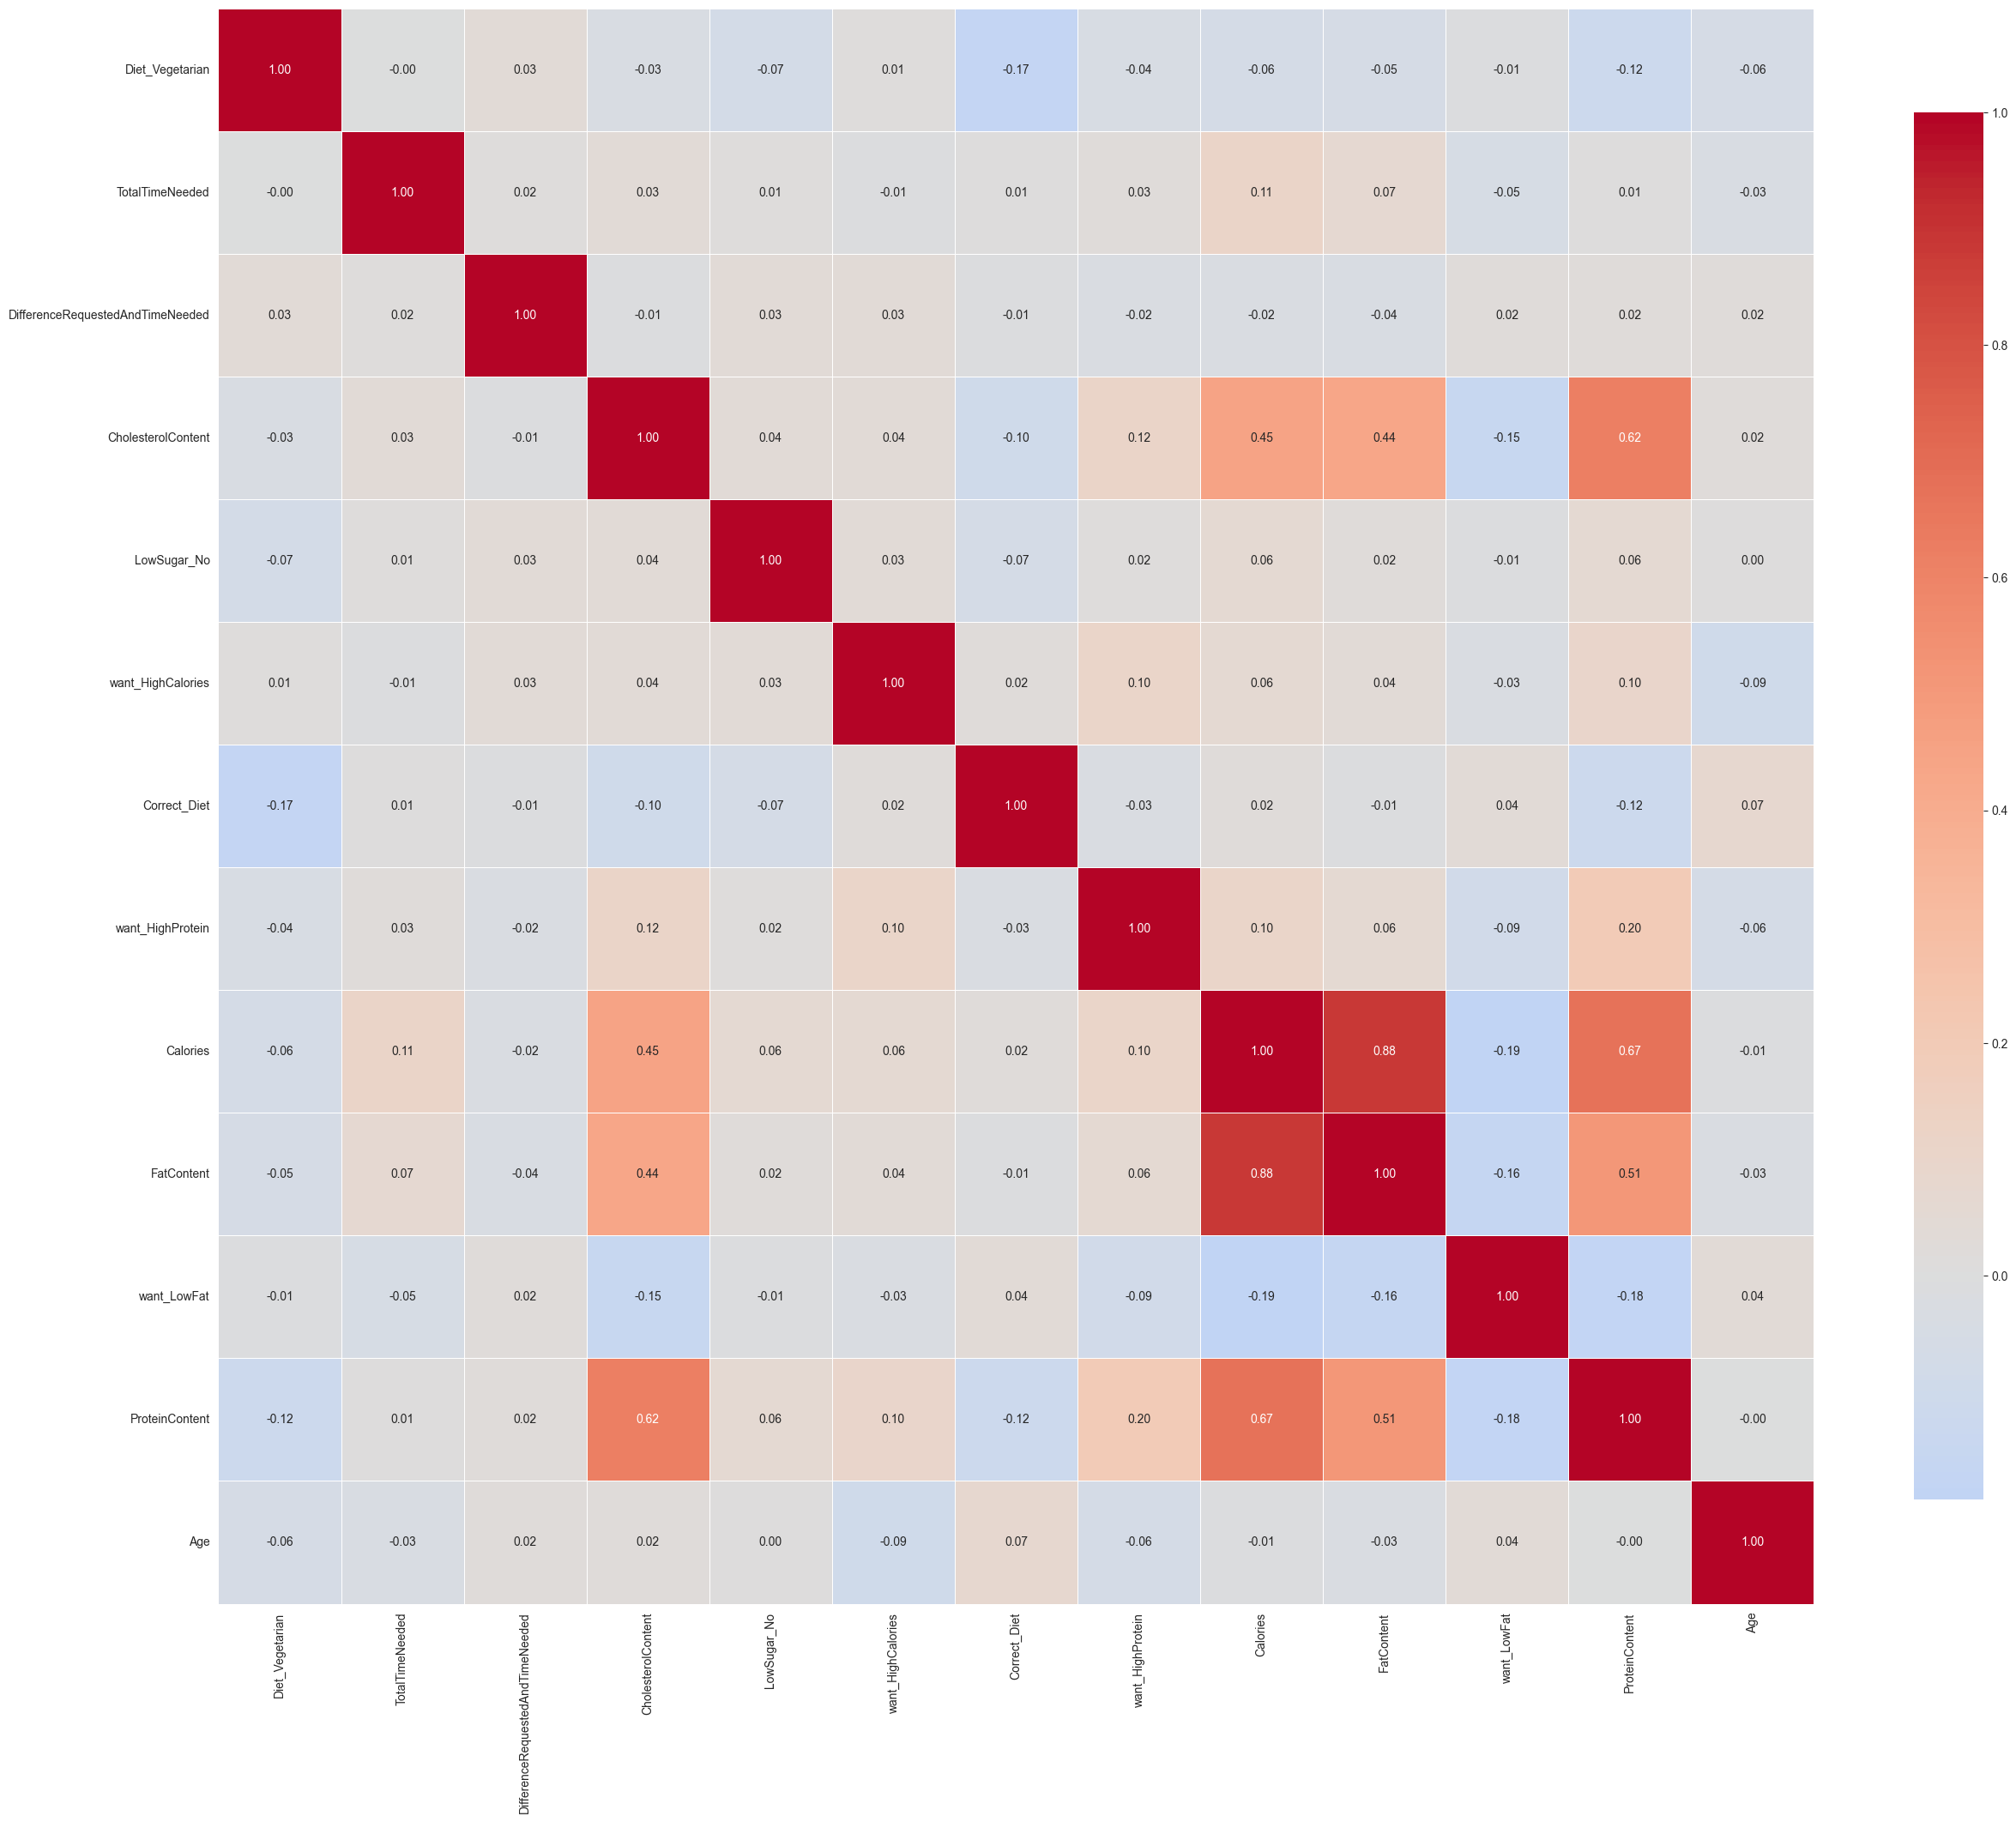

In [580]:
def correlation_heatmap(train):
    correlations = train.corr()
    
    fig, ax = plt.subplots(figsize=(30,30))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    
    plt.show();

correlation_heatmap(X_train[X.columns[sorted_idx]])

Test Balanced Accuracy: 0.8446099097873884


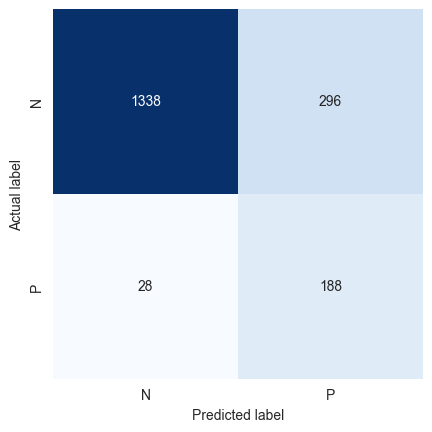

In [581]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_lunch.predict(X_test) > 0.5
mat = confusion_matrix(y_test_lunch, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_lunch = balanced_accuracy_score(y_test_lunch, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_lunch}')

TN_Lunch, FP_Lunch = mat[0, 0], mat[0, 1]
FN_Lunch, TP_Lunch = mat[1, 0], mat[1, 1]

## breakfast

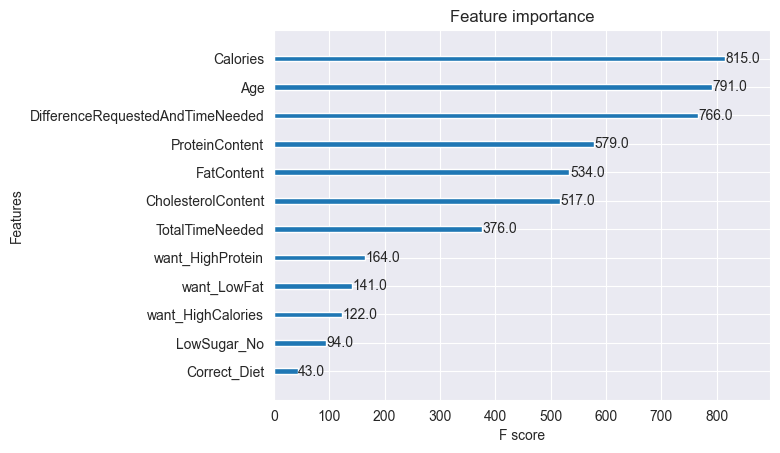

In [582]:
breakfast_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'RecipeCategory', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product','SaturatedFatContent', 'RecipeServings', 'CarbohydrateContent', 'SodiumContent', 'SugarContent', 'CookTime', 'PrepTime', 'Diet_Vegetarian', 'Diet_Vegan', 'FiberContent', 'want_HighFiber' ]
X = breakfast_subset.drop(breakfast_variables_to_drop, axis=1)
y = breakfast_subset['Like']

X_train, X_test, y_train, y_test_breakfast = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3, 
                     stratify=y)

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

model_breakfast = XGBRegressor(n_estimators=100, random_state=seed)
model_breakfast.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_breakfast)
plt.show()

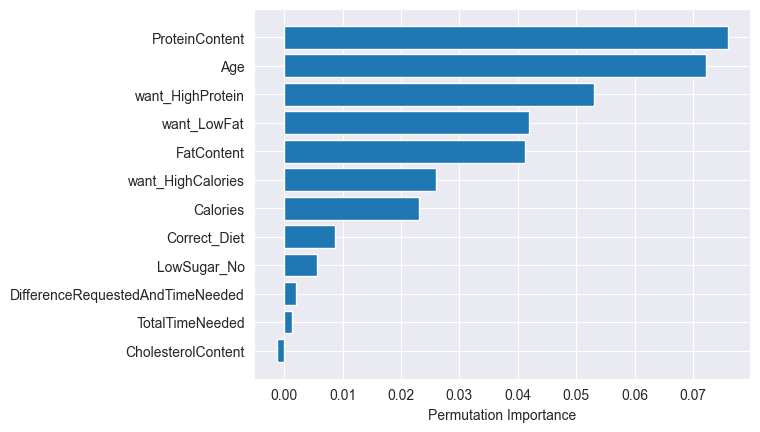

In [583]:
model_breakfast = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_breakfast.fit(X_train, y_train)
models.append(model_breakfast)

perm_importance = permutation_importance(model_breakfast, X_test, y_test_breakfast)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.8413424866514111


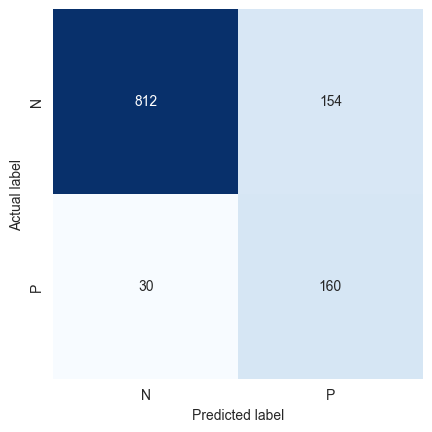

In [584]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_breakfast.predict(X_test) > 0.5
mat = confusion_matrix(y_test_breakfast, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_breakfast = balanced_accuracy_score(y_test_breakfast, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_breakfast}')

TN_Breakfast, FP_Breakfast = mat[0, 0], mat[0, 1]
FN_Breakfast, TP_Breakfast = mat[1, 0], mat[1, 1]

## Bread

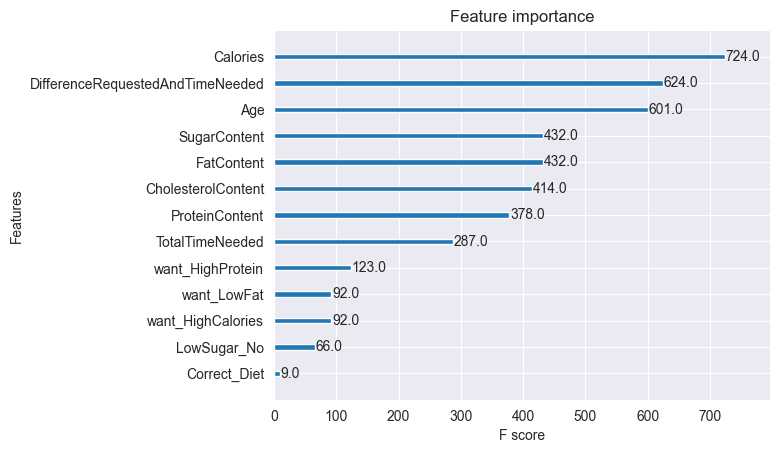

In [585]:
bread_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'RecipeCategory', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product','SaturatedFatContent', 'RecipeServings', 'CarbohydrateContent', 'SodiumContent', 'CookTime', 'PrepTime', 'Diet_Vegetarian', 'Diet_Vegan', 'FiberContent', 'want_HighFiber' ]
X = bread_subset.drop(bread_variables_to_drop, axis=1)
y = bread_subset['Like']

X_train, X_test, y_train, y_test_bread = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3, 
                     stratify=y)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

model_bread = XGBRegressor(n_estimators=100, random_state=seed)
model_bread.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_bread)
plt.show()

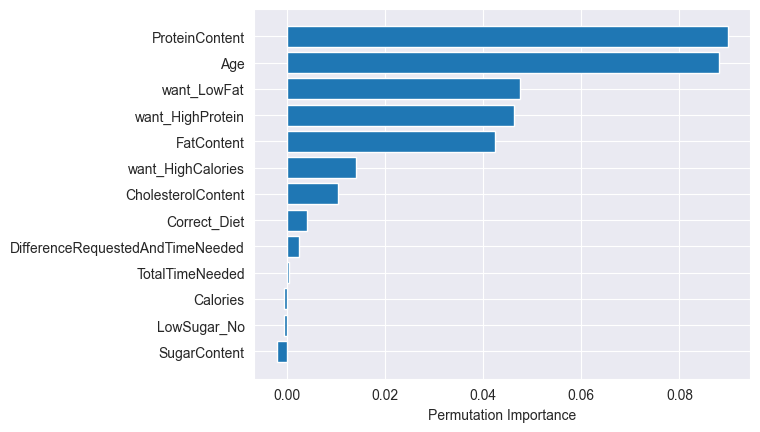

In [586]:
model_bread = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_bread.fit(X_train, y_train)
models.append(model_bread)

perm_importance = permutation_importance(model_bread, X_test, y_test_bread)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.8265340262151063


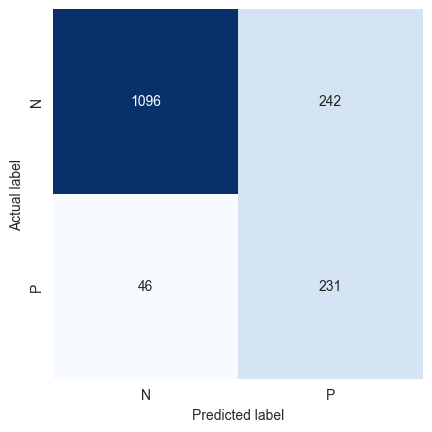

In [587]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_bread.predict(X_test) > 0.5
mat = confusion_matrix(y_test_bread, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_bread = balanced_accuracy_score(y_test_bread, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_bread}')

TN_Bread, FP_Bread = mat[0, 0], mat[0, 1]
FN_Bread, TP_Bread = mat[1, 0], mat[1, 1]

## one_dish_meal

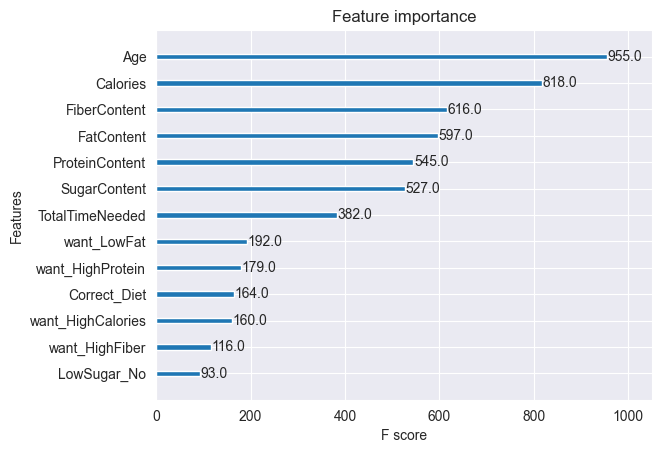

In [588]:
one_dish_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield', 'for_Vegetarian', 'RecipeCategory','for_Vegan', 'has_fish_meat', 'has_animal_product', 'SodiumContent', 'CholesterolContent', 'MaxTime', 'PrepTime', 'CookTime', 'Diet_Vegan', 'Diet_Vegetarian', 'SaturatedFatContent', 'RecipeServings', 'CarbohydrateContent', 'DifferenceRequestedAndTimeNeeded']
X = one_dish_meal_subset.drop(one_dish_variables_to_drop, axis=1)
y = one_dish_meal_subset['Like']

X_train, X_test, y_train, y_test_one_dish = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3, 
                     stratify=y)

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

model_one_dish = XGBRegressor(n_estimators=100, random_state=seed)
model_one_dish.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_one_dish)
plt.show()

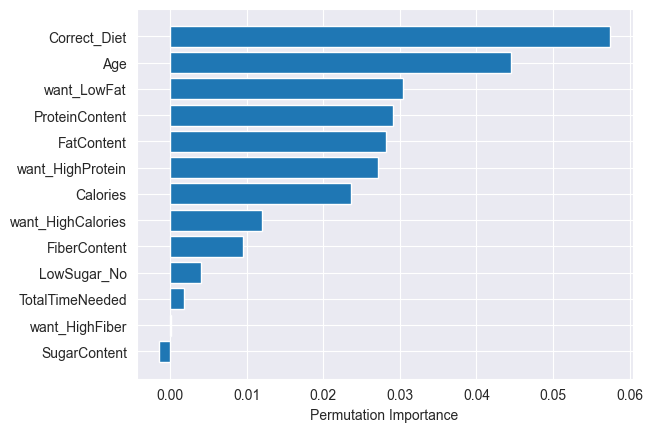

In [589]:
model_one_dish = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_one_dish.fit(X_train, y_train)
models.append(model_one_dish)

perm_importance = permutation_importance(model_one_dish, X_test, y_test_one_dish)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.860619057461761


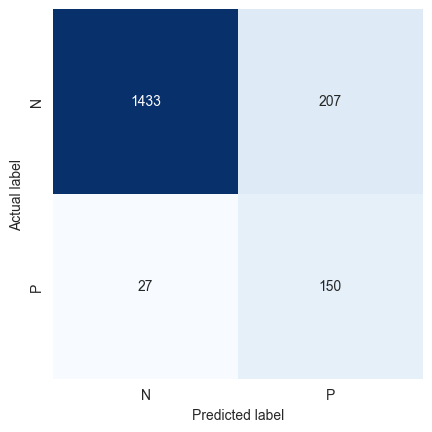

In [590]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_one_dish.predict(X_test) > 0.5
mat = confusion_matrix(y_test_one_dish, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_one_dish = balanced_accuracy_score(y_test_one_dish, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_one_dish}')
TN_One_Dish, FP_One_Dish = mat[0, 0], mat[0, 1]
FN_One_Dish, TP_One_Dish = mat[1, 0], mat[1, 1]

## other

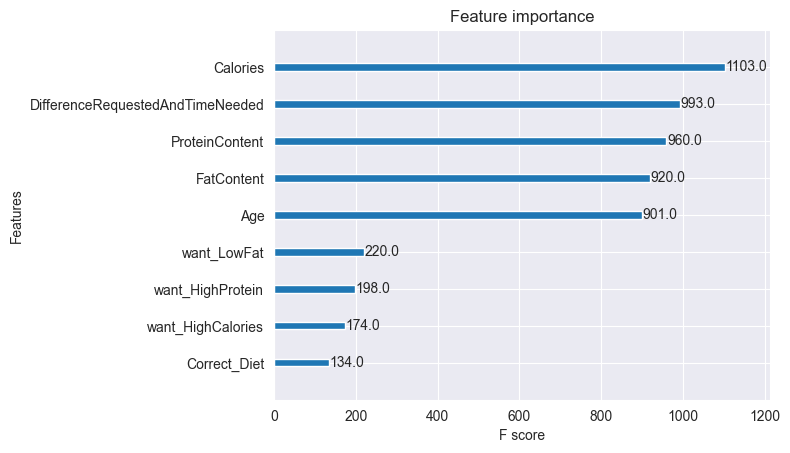

In [591]:
other_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime', 'RecipeCategory','for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', 'SaturatedFatContent', 'RecipeServings', 'PrepTime', 'CookTime', 'Diet_Vegetarian', 'Diet_Vegan', 'CarbohydrateContent', 'SodiumContent', 'CholesterolContent', 'want_HighFiber', 'FiberContent', 'SugarContent', 'LowSugar_No', 'TotalTimeNeeded']
X = other_subset.drop(other_variables_to_drop, axis=1)
y = other_subset['Like']

X_train, X_test, y_train, y_test_other = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

model_other = XGBRegressor(n_estimators=100, random_state=seed)
model_other.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_other)
plt.show()

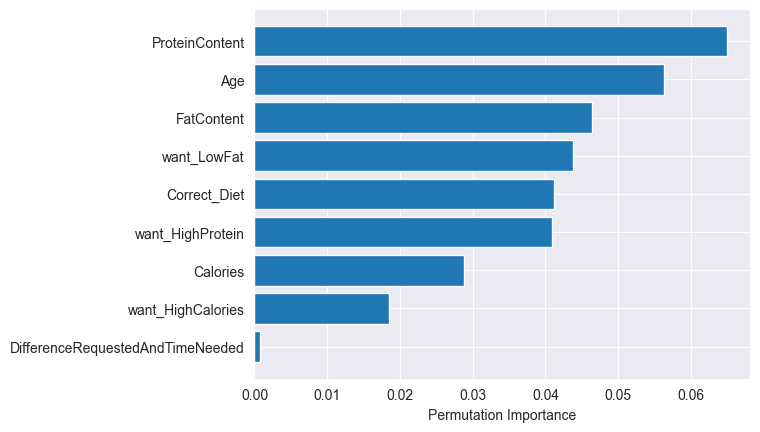

In [592]:
model_other = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_other.fit(X_train, y_train)
models.append(model_other)

perm_importance = permutation_importance(model_other, X_test, y_test_other)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.8536599451042204


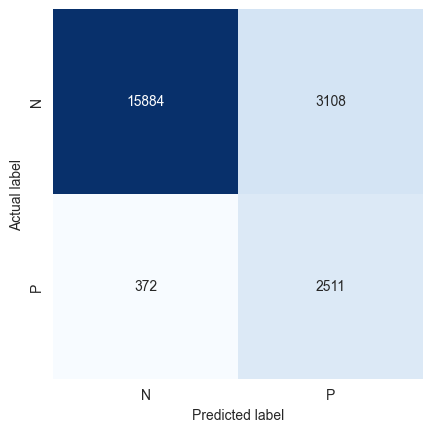

In [593]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_other.predict(X_test) > 0.5
mat = confusion_matrix(y_test_other, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_other = balanced_accuracy_score(y_test_other, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_other}')
TN_Other, FP_Other = mat[0, 0], mat[0, 1]
FN_Other, TP_Other = mat[1, 0], mat[1, 1]

## Beverages

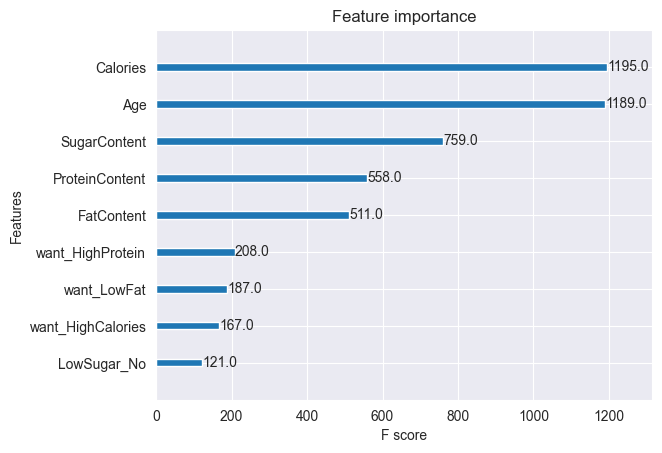

In [594]:
beverages_variables_to_drop = ['CustomerId', 'RecipeId', 'Like', 'Name', 'RecipeIngredientQuantities', 'RecipeIngredientParts', 'RecipeYield','MaxTime','RecipeCategory', 'for_Vegetarian', 'for_Vegan', 'has_fish_meat', 'has_animal_product', 'RecipeServings', 'SaturatedFatContent', 'PrepTime', 'CookTime', 'SodiumContent', 'Diet_Vegan', 'Diet_Vegetarian', 'CholesterolContent', 'CarbohydrateContent', 'DifferenceRequestedAndTimeNeeded', 'TotalTimeNeeded', 'Correct_Diet', 'RecipeServings', 'FiberContent', 'want_HighFiber']
X = beverages_subset.drop(beverages_variables_to_drop, axis=1)

y = beverages_subset['Like']

X_train, X_test, y_train, y_test_beverages = \
    train_test_split(X, y,
                     test_size=0.3,
                     shuffle=True,
                     random_state=3)

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=seed)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

model_beverages = XGBRegressor(n_estimators=100, random_state=seed)
model_beverages.fit(X_train, y_train)

# Plot feature importance
plot_importance(model_beverages)
plt.show()

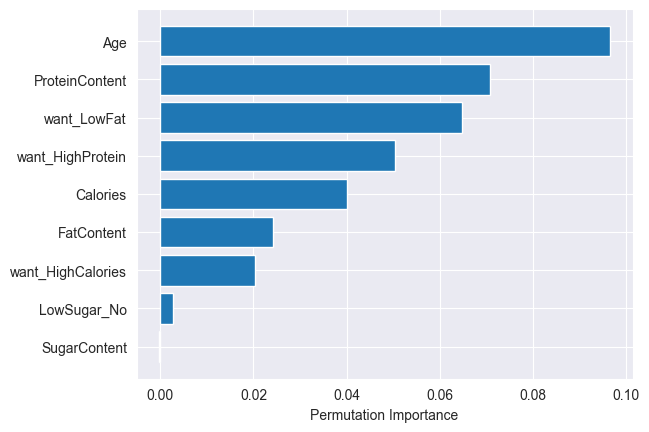

In [595]:
model_beverages = GradientBoostingClassifier(n_estimators=100, random_state=seed)
model_beverages.fit(X_train, y_train)
models.append(model_beverages)

perm_importance = permutation_importance(model_beverages, X_test, y_test_beverages)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

Test Balanced Accuracy: 0.8441597081317309


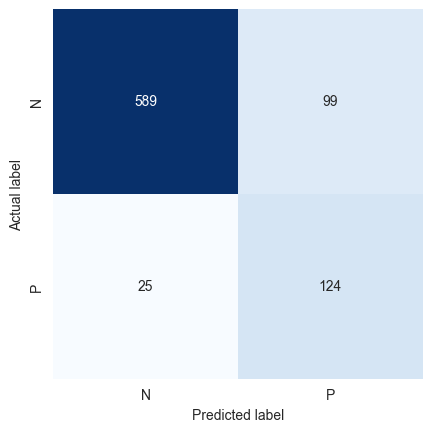

In [596]:
from sklearn.metrics import confusion_matrix
 
y_predicted = model_beverages.predict(X_test) > 0.5
mat = confusion_matrix(y_test_beverages, y_predicted)
labels = ['N', 'P']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')
balanced_acc_beverages = balanced_accuracy_score(y_test_beverages, y_predicted)

print(f'Test Balanced Accuracy: {balanced_acc_beverages}')

TN_Beverages, FP_Beverages = mat[0, 0], mat[0, 1]
FN_Beverages, TP_Beverages = mat[1, 0], mat[1, 1]

# Calculate balanced_accuracy all models

In [597]:
from sklearn.metrics import balanced_accuracy_score

# Option one
overall_balanced_acc = (balanced_acc_soup + balanced_acc_bread + balanced_acc_lunch + balanced_acc_other + balanced_acc_beverages + balanced_acc_breakfast+ balanced_acc_one_dish) / 7

# Option two 
TP = TP_Soup + TP_Bread + TP_Lunch + TP_Other + TP_Beverages + TP_Breakfast + TP_One_Dish
TN = TN_Soup + TN_Bread + TN_Lunch + TN_Other + TN_Beverages + TN_Breakfast + TN_One_Dish
FP = FP_Soup + FP_Bread + FP_Lunch + FP_Other + FP_Beverages + FP_Breakfast + FP_One_Dish
FN = FN_Soup + FN_Bread + FN_Lunch + FN_Other + FN_Beverages + FN_Breakfast + FN_One_Dish

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)

balanced_accuracy = (TPR + TNR) / 2
print("Overall Balanced Accuracy:", overall_balanced_acc)
print("Overall Balanced Accuracy:", balanced_accuracy)

Overall Balanced Accuracy: 0.8375326302914489
Overall Balanced Accuracy: 0.8508938746318555


In [598]:
subset_names = ['Soup', 'Bread', 'Lunch', 'Other', 'Breakfast', 'One Dish Meal', 'Beverages']
y_test_combined = pd.concat([y_test_soup, y_test_bread, y_test_lunch, y_test_other, y_test_breakfast, y_test_one_dish, y_test_beverages], axis=0)
# Print class distribution for each subset
for subset_name, y_test_subset in zip(subset_names, [y_test_soup, y_test_bread, y_test_lunch, y_test_other, y_test_breakfast, y_test_one_dish, y_test_beverages]):
    print(f"Class Distribution for {subset_name}:\n{y_test_subset.value_counts()}\n")

# Print class distribution for the combined dataset
print("Class Distribution for Combined Dataset:\n", y_test_combined.value_counts())


Class Distribution for Soup:
Like
False    61
True      5
Name: count, dtype: Int64

Class Distribution for Bread:
Like
False    1338
True      277
Name: count, dtype: Int64

Class Distribution for Lunch:
Like
False    1634
True      216
Name: count, dtype: Int64

Class Distribution for Other:
Like
False    18992
True      2883
Name: count, dtype: Int64

Class Distribution for Breakfast:
Like
False    966
True     190
Name: count, dtype: Int64

Class Distribution for One Dish Meal:
Like
False    1640
True      177
Name: count, dtype: Int64

Class Distribution for Beverages:
Like
False    688
True     149
Name: count, dtype: Int64

Class Distribution for Combined Dataset:
 Like
False    25319
True      3897
Name: count, dtype: Int64


In [612]:
# Split test_set into subsets 
test_soup = test_set[test_set['RecipeCategory'] == 'Soup']
test_lunch = test_set[test_set['RecipeCategory'] == 'Lunch']
test_breakfast = test_set[test_set['RecipeCategory'] == 'Breakfast']
test_bread = test_set[test_set['RecipeCategory'] == 'Bread']
test_one_dish = test_set[test_set['RecipeCategory'] == 'One dish meal']
test_other = test_set[test_set['RecipeCategory'] == 'Other']
test_beverages = test_set[test_set['RecipeCategory'] == 'Beverages']

# drop variables
test_soup = test_soup.drop(soup_variables_to_drop, axis=1)
test_lunch = test_lunch.drop(lunch_variables_to_drop, axis=1)
test_breakfast = test_breakfast.drop(breakfast_variables_to_drop, axis=1)
test_bread = test_bread.drop(bread_variables_to_drop, axis=1)
test_one_dish = test_one_dish.drop(one_dish_variables_to_drop, axis=1)
test_other = test_other.drop(other_variables_to_drop, axis=1)
test_beverages = test_beverages.drop(beverages_variables_to_drop, axis=1)


# Make predictions on each subset using the corresponding model
test_soup['prediction'] = model_soup.predict(test_soup.drop(['TestSetId'], axis=1))
test_lunch['prediction'] = model_lunch.predict(test_lunch.drop(['TestSetId'], axis=1))
test_breakfast['prediction'] = model_breakfast.predict(test_breakfast.drop(['TestSetId'], axis=1))
test_bread['prediction'] = model_bread.predict(test_bread.drop(['TestSetId'], axis=1))
test_one_dish['prediction'] = model_one_dish.predict(test_one_dish.drop(['TestSetId'], axis=1))
test_other['prediction'] = model_other.predict(test_other.drop(['TestSetId'], axis=1))
test_beverages['prediction'] = model_beverages.predict(test_beverages.drop(['TestSetId'], axis=1))

test_output = pd.concat([
    pd.DataFrame({"id": test_soup["TestSetId"].astype(int), "prediction": test_soup["prediction"].astype(int)}),
    pd.DataFrame({"id": test_lunch["TestSetId"].astype(int), "prediction": test_lunch["prediction"].astype(int)}),
    pd.DataFrame({"id": test_breakfast["TestSetId"].astype(int), "prediction": test_breakfast["prediction"].astype(int)}),
    pd.DataFrame({"id": test_bread["TestSetId"].astype(int), "prediction": test_bread["prediction"].astype(int)}),
    pd.DataFrame({"id": test_one_dish["TestSetId"].astype(int), "prediction": test_one_dish["prediction"].astype(int)}),
    pd.DataFrame({"id": test_other["TestSetId"].astype(int), "prediction": test_other["prediction"].astype(int)}),
    pd.DataFrame({"id": test_beverages["TestSetId"].astype(int), "prediction": test_beverages["prediction"].astype(int)})
], ignore_index=True)

test_output = test_output.sort_values(by="id").reset_index(drop=True)
test_output.to_csv("predictions_LetsSeePaulAllens'BAC_test.csv", index=False)

In [614]:
test_output1 = pd.read_csv("predictions_LetsSeePaulAllens'BAC_4.csv").copy()
test_output2 = pd.read_csv("predictions_LetsSeePaulAllens'BAC_test.csv").copy()

merged_predictions = pd.merge(test_output1, test_output2, on="id", suffixes=('_1', '_2'))

merged_predictions['prediction_differs'] = merged_predictions['prediction_1'] != merged_predictions['prediction_2']

# Filter rows where predictions differ
differing_predictions = merged_predictions[merged_predictions['prediction_differs']]
differing_predictions.to_csv('differing_predictions.csv', index=False)

percentage_difference = (len(differing_predictions) / len(merged_predictions)) * 100

print(f"Percentage of differing predictions: {percentage_difference}%")
print("Rows where predictions differ:")
print(differing_predictions[['id', 'prediction_1', 'prediction_2']])


Percentage of differing predictions: 9.594992292240857%
Rows where predictions differ:
          id  prediction_1  prediction_2
1          2             1             0
5          6             1             0
9         10             0             1
19        20             1             0
31        32             0             1
...      ...           ...           ...
42758  42759             1             0
42762  42763             0             1
42780  42781             1             0
42790  42791             1             0
42807  42808             1             0

[4108 rows x 3 columns]
